Code for examining how HMM performs under repeated recalibration


In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.linear_model import LinearRegression


import sys, glob
[sys.path.append(f) for f in glob.glob('../utils/*')]
from plotting_utils import figSize
from simulation_utils import * 
from simulation import simulateBCIFitts
from stabilizer_utils import *

# for a reproducible result
np.random.seed(1)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Define an initial decoder and initial neural tuning properties (mean firing rates and preferred directions).


In [5]:
from sklearn.linear_model import LinearRegression
from simulation_utils import simulateUnitActivity

'''The first column of initialTuning is the means, and the second two columns are the preferred directions. 
We make sure that the last two columns are orthogonal (uniformly distributed PDs)'''

nUnits         = 192
SNR            = 0.5
nTrainingSteps = 10000

initialTuning          = generateUnits(n_units = nUnits, SNR = SNR)
initialTuning[:, 0]    = 0  # for now - assume features are centered 
calNeural, calVelocity = simulateUnitActivity(initialTuning, noise = 0.3, nSteps = nTrainingSteps)

lr             = LinearRegression(fit_intercept = True).fit(calNeural, calVelocity)
D              = np.hstack([lr.intercept_[:, np.newaxis], lr.coef_]).T

# Normalize the gain of this decoder so that it will output vectors with a magnitude of 1 when the encoded velocity has a magnitude of 1. 
D[:, 0] = D[:,0] / np.linalg.norm(D[1:, :][:, 0]) / np.linalg.norm(initialTuning[:, 1])
D[:, 1] = D[:,1] / np.linalg.norm(D[1:, :][:, 1]) / np.linalg.norm(initialTuning[:, 2])

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
Using gain value beta =  1.3888888888888888


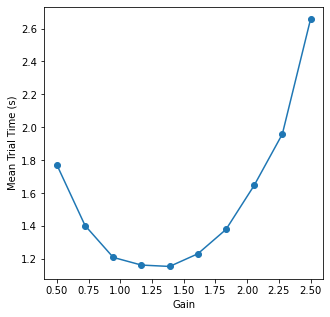

In [6]:
'''Here we define the amount of exponential smoothing used in the decoder (alpha). Values between 0.9 and 0.96 are pretty reasonable. See the paper
'A comparison of intention estimation methods for decoder calibration in intracortical brain-computer interfaces' for an explanation of how velocity Kalman 
filters can be parameterized with a smoothing parameter (alpha), gain parameter (beta, see next section below) and decoding matrix (D). '''

alpha       = 0.94
delT        = 0.01 # define the time step (10 ms)
nDelaySteps = 20   # define the simulated user's visual feedback delay (200 ms)
nSimSteps   = 50000

import matplotlib.pyplot as plt 
figSize(5,5)

possibleGain = np.linspace(0.5,2.5,10)
meanTTT      = np.zeros((len(possibleGain),))

for g in range(len(possibleGain)):
    print(str(g) + ' / ' + str(len(possibleGain)))
    posTraj, velTraj, rawDecTraj, conTraj, targTraj, neuralTraj, trialStart, ttt = simulateBCIFitts(initialTuning, D,alpha, possibleGain[g], nDelaySteps, delT, nSimSteps)
    meanTTT[g] = np.mean(ttt)

plt.figure()
plt.plot(possibleGain, meanTTT, '-o')
plt.xlabel('Gain')
plt.ylabel('Mean Trial Time (s)')

minIdx = np.argmin(meanTTT)
beta   = possibleGain[minIdx]

print('Using gain value beta = ', beta)

In [15]:
from stabilizer_utils import get_TrialStartActivity

# general settings:
n_sessions   = 30     # number of sessions to simulate 
days_between = 0      # days between sessions
reps         = 10     # how many times to repeat the repeated nonstationarities simulation
nSimSteps    = 10000  # number of timesteps for simulating session usage 
shrinkage    = 0.92   # relative tuning in subspace per new day


# Stabilizer settings:
model_type  = 'FactorAnalysis'
d           = 9
B           = 100
thresh      = 0.05

wait_for    = 20  # time (bins) after trial starts to wait until collecting data
n_bins      = 30  # grab this many bins of activity for each trial


#-----------------------------------------
session_scores  = np.zeros((reps, n_sessions + 1, 2)) # 0: no recalibration, 1: subspace stabilizer


for n in range(reps):
    # Day 0 performance: standard decoder
    lr      = LinearRegression(fit_intercept = True).fit(calNeural, calVelocity)
    D       = np.hstack([lr.intercept_[:, np.newaxis], lr.coef_]).T
    D[:, 0] = D[:,0] / np.linalg.norm(D[1:, :][:, 0]) / np.linalg.norm(initialTuning[:, 1])  # Normalize the gain so that it outputs vectors with a magnitude of 1 when the encoded velocity has a magnitude of 1
    D[:, 1] = D[:,1] / np.linalg.norm(D[1:, :][:, 1]) / np.linalg.norm(initialTuning[:, 2])
    
    _, _, _, _, _, neuralTraj, trialStart, ttt = simulateBCIFitts(initialTuning, D, alpha, beta, nDelaySteps, delT, nSimSteps)
    session_scores[:, 0, 0] = np.mean(ttt)
    
    # Day 0 performance: subspace-based decoder 
    stab  = Stabilizer(model_type = model_type, n_components = d)
    ref_stab_input = get_TrialStartActivity(neuralTraj, trialStart, wait_for = wait_for, n_bins = n_bins)
    #ref_stab_input = calNeural
    stab           = stab.fit_ref([ref_stab_input])
    
    Q_ref        = get_FactorAnalysisMap(stab.ref_model)
    calLatent    = (calNeural - calNeural.mean(axis = 0)).dot(Q_ref)
    lr           = LinearRegression(fit_intercept = True).fit(calLatent, calVelocity)

    h      = lr.coef_                                             # map from latent space onto targets
    D_coef = h.dot(Q_ref.T)                                       # compose to get neural --> latent --> output 
    D_SS   = np.hstack([lr.intercept_[:, np.newaxis], D_coef]).T  # add bias terms

    D_SS[:, 0] = D_SS[:,0] / np.linalg.norm(D_SS[1:, :][:, 0]) / np.linalg.norm(initialTuning[:, 1])
    D_SS[:, 1] = D_SS[:,1] / np.linalg.norm(D_SS[1:, :][:, 1]) / np.linalg.norm(initialTuning[:, 2])
    
    ttt                     = simulateBCIFitts(initialTuning, D_SS, alpha, beta, nDelaySteps, delT, nSimSteps)[-1]
    session_scores[:, 0, 1] = np.mean(ttt)
    
    tuning = np.copy(initialTuning)
    for i in range(n_sessions):
        for j in range(days_between + 1):
            tuning = simulateTuningShift(tuning, PD_shrinkage = shrinkage, mean_shift = 0, renormalize = True)  # introduce daily nonstationarities between recorded sessions
        
        # simulate no recalibration:
        ttt = simulateBCIFitts(tuning, D, alpha, beta, nDelaySteps, delT, nSimSteps)[-1] 
        session_scores[n, i+1, 0]  = np.mean(ttt)
        
        # simulate old decoder on new session
        cursorPos, _, decOut, _, targTraj, neural_new, trialStart_new, ttt = simulateBCIFitts(tuning, D_SS, alpha, beta, nDelaySteps, delT, nSimSteps) 
        new_stab_input = get_TrialStartActivity(neural_new, trialStart_new, wait_for = wait_for, n_bins = n_bins)
        #new_stab_input = neural_new
        
        stab.fit_new([new_stab_input], B = B, thresh = thresh)
        G_new      = get_FactorAnalysisMap(stab.new_model)
        D_coefnew  = h.dot(G_new.dot(stab.R).T)                                # compose to get neural --> latent --> output 
        D_SS       = np.hstack([lr.intercept_[:, np.newaxis], D_coefnew]).T    # add bias terms
        decVec_new = np.hstack([np.ones((neural_new.shape[0], 1)), neural_new]).dot(D_SS)

        #Important: normalize the decoder so that D_new decoders vectors of magnitude 1 when far from the target. 
        #This will restore the original optimal gain.
        PosErr   = targTraj - cursorPos
        TargDist = np.linalg.norm(PosErr, axis = 1)
        TargDir  = PosErr / TargDist[:, np.newaxis]
        farIdx   = np.where(TargDist > 0.4)[0]
        projVec  = np.sum(np.multiply(decVec_new[farIdx, :], TargDir[farIdx, :]), axis = 1)
        D_SS    /= np.mean(projVec)

        ttt_SS                     = simulateBCIFitts(tuning, D_SS, alpha, beta, nDelaySteps, delT, nSimSteps)[-1] #Simulate BCI performance with the HMM-recalibrated decoder
        session_scores[n, i+1, 1]  = np.mean(ttt_SS)
    print(n + 1, '/', reps, 'complete')

1 / 10 complete
2 / 10 complete
3 / 10 complete
4 / 10 complete
5 / 10 complete
6 / 10 complete
7 / 10 complete
8 / 10 complete
9 / 10 complete
10 / 10 complete


Text(0, 0.5, 'Time to target (sec)')

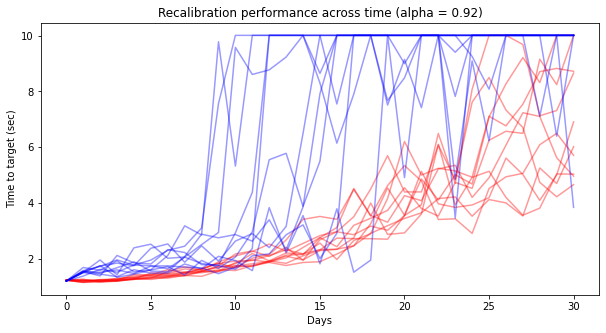

In [17]:
figSize(5, 10)
from lineplots import plotsd

labels = ['None', 'Subspace stabilizer']
colors = ['r',  'b']
days   = np.linspace(0, (days_between + 1) * n_sessions, n_sessions + 1)

for i, label in enumerate(labels):
    plt.plot(session_scores[:, :, i].T,  color = colors[i], label = labels[i], alpha = 0.4)
    #plotsd(data = session_scores[:, :, i], time_bins = days, color = colors[i], toggleSE = True)

#plt.legend()
#plt.legend(labels, loc = 'upper left')
plt.title('Recalibration performance across time (alpha = ' + str(shrinkage) + ')')
plt.xlabel('Days')
plt.ylabel('Time to target (sec)')